# Internet Advertising: Predicting Engagement with Ads
In this project, I will be analyzing and predicting whether a particular internet user will click on an advertisement. 

I am completing this project as part of the online Udemy course "Python for Data Science and Machine Learning Bootcamp"

The goal of this project is to use previous advertisement engagement data to create a model that will predict whether a user will click on an ad or not in the future. As this is a binary, classifying decision, I will be using logistic regression to model this data. 

# Import Libraries and Retrieve Data

In [83]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [84]:
ad_data = pd.read_csv('advertising.csv')

In [85]:
ad_data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0


We're given this information regarding each column:
* 'Daily Time Spent on Site': consumer time on site in minutes
* 'Age': cutomer age in years
* 'Area Income': Avg. Income of geographical area of consumer
* 'Daily Internet Usage': Avg. minutes a day consumer is on the internet
* 'Ad Topic Line': Headline of the advertisement
* 'City': City of consumer
* 'Male': Whether or not consumer was male
* 'Country': Country of consumer
* 'Timestamp': Time at which consumer clicked on Ad or closed window
* 'Clicked on Ad': 0 or 1 indicated clicking on Ad

I assume that Area income is in USD.

In [86]:
ad_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
Daily Time Spent on Site    1000 non-null float64
Age                         1000 non-null int64
Area Income                 1000 non-null float64
Daily Internet Usage        1000 non-null float64
Ad Topic Line               1000 non-null object
City                        1000 non-null object
Male                        1000 non-null int64
Country                     1000 non-null object
Timestamp                   1000 non-null object
Clicked on Ad               1000 non-null int64
dtypes: float64(3), int64(3), object(4)
memory usage: 78.2+ KB


It looks like, from this, that we aren't missing any data, so there isn't any particular cleaning we need to do because of that. If we clean the data, it will be for feature engineering to extract information from text-based columns

In [87]:
ad_data.describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,65.000200,36.009000,55000.000080,180.000100,0.481000,0.50000
std,15.853615,8.785562,13414.634022,43.902339,0.499889,0.50025
min,32.600000,19.000000,13996.500000,104.780000,0.000000,0.00000
25%,51.360000,29.000000,47031.802500,138.830000,0.000000,0.00000
50%,68.215000,35.000000,57012.300000,183.130000,0.000000,0.50000
75%,78.547500,42.000000,65470.635000,218.792500,1.000000,1.00000
max,91.430000,61.000000,79484.800000,269.960000,1.000000,1.00000


Also, from this data, we see that our target variable is balanced, meaning there is an equal number of binary choices in our dataset, so that we do not need to balance it ourselves as part of this analysis.

# Exploratory Data Analysis (EDA)
First, I'll explore the data to get a better understanding of what is happening. With Clicked on Ad being the variable in question, I'll be looking for the factors that could impact this the most. 

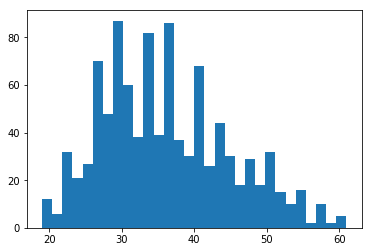

In [88]:
#Age is one of the most obvious factors that would potentially affect click rate
_ = plt.hist(ad_data['Age'], bins = 30)

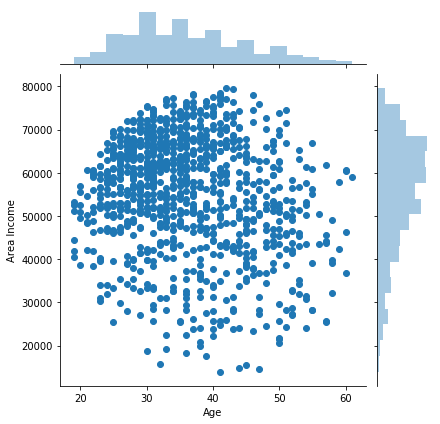

In [89]:
#Assuming Area Income is also affected by age and could be enlightning for whether they click or not
sns.jointplot(ad_data['Age'],ad_data['Area Income'])

We see a larger concentration in the top left. Knowing there are more users of younger age, it makes sense that there would be a higher density on the left side of the graph. However, It looks like he majority of those younger people have an income above $45,000.

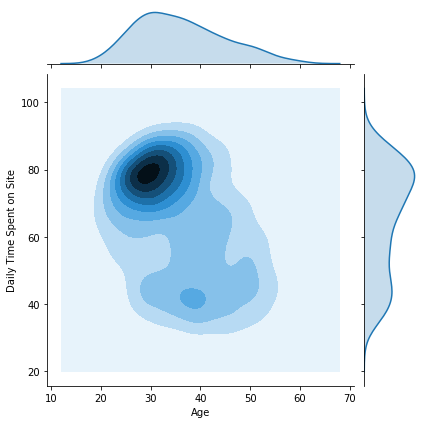

In [90]:
#Daily Time Spent on Site is also another factor that could be important in determining what the user does.
#Of course, Daily Time Spent on Site will also be very different given the user's age.
sns.jointplot(ad_data['Age'],ad_data['Daily Time Spent on Site'], kind='kde')

We see from this that most of these users are between 25 and 40 and spend over 60 minutes on the site each day.

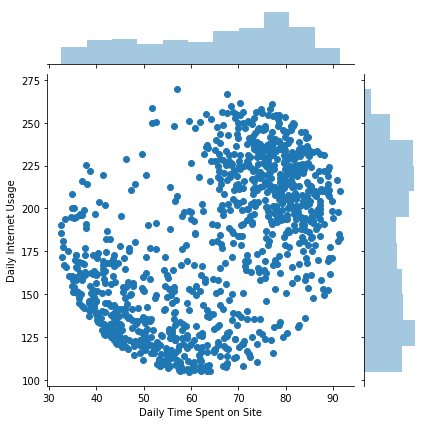

In [91]:
#Is the daily time spent on site the same as the daily internet usage?
sns.jointplot(ad_data['Daily Time Spent on Site'],ad_data['Daily Internet Usage'])

With almost a circular dataset, users usage is pretty spread out, with concentrations roughly being in high internet usage and high daily time spent on site and low internet usage and low daily time spent on site. 

With a better understand of what our users are like, let's plot them all together in regards to whether they clicked on the Ad or not to give us some visual understanding of what's happening.

C:\Users\Brandon\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\Brandon\Anaconda3\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


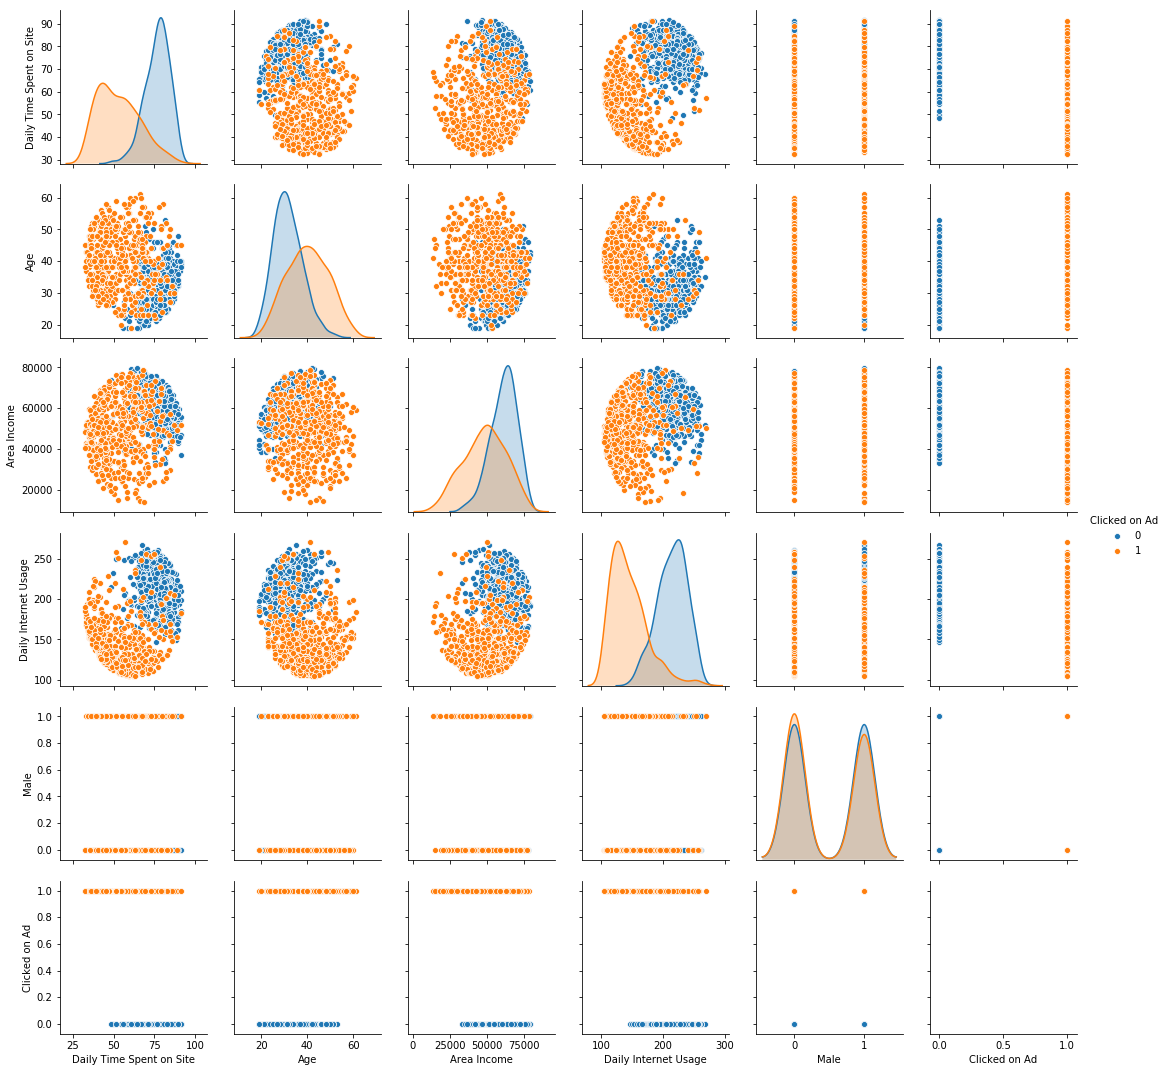

In [92]:
sns.pairplot(ad_data, hue = 'Clicked on Ad', diag_kind = 'auto')

What's clear from the above is that there is a higher concentration of people who clicked on the ad if they:
1. Spent less time on the Site
2. Spent less time on the Internet every day

Visually, these seem to be the identifying factors in whether they will click on an ad. Now I'll move on to performing a logistic regression to determine if these variables are as important as I hypothesize.

# Building a Logistic Regression Model

## Preparing our data
Now we'll prepare our data to be used in our model
Now it's time to split on data set into two, train the model, and test how it performs.

I will be dropping the Ad Header and City columns for the first model. 

The Ad topic line, while certainly useful, you would need to bin each ad because each ad is unique, causing the way you bin to cause more bias as well as you decide how to classify the ads. In the future, it would be better to group ad topics into a larger group to avoid having to manually extract this data from the granularity. Even without this, however, we can get a model that will be able to predict based on other factors of our users. 

I'm assuming, for this relatively small data set, city will not be impactful enough to make much of a difference in my analysis, though I will be keeping country in as a dummy variable. We'll be changing the timestamp data into months.

In [93]:
#Want to make a copy of our data. Though we didn't have to clean our data, we want to be able to return to this point if we want to add or drop data
ad_data1= ad_data.copy()

In [94]:
import datetime as dt
ad_data1['Timestamp'] = pd.to_datetime(ad_data1['Timestamp'])
ad_data1['Month'] = ad_data1['Timestamp'].dt.month
ad_data1.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad,Month
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:11,0,3
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:02,0,4
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:42,0,3
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:19,0,1
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:18,0,6


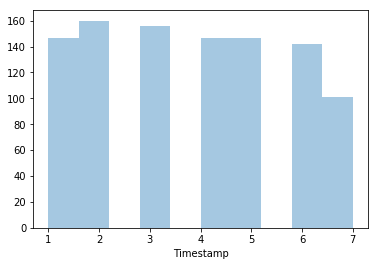

In [95]:
#Want to see the distribution of dates
sns.distplot(ad_data1['Timestamp'].dt.month, kde=False)

It looks like the dates have a fairly uniform distribution, so I don't expect it to be incredibly impactful, but I'll include it in the first model and then eliminate it when appropriate.

In [96]:
#create a dummy variable for month
month_dummy = pd.get_dummies(ad_data1['Month'],drop_first=True)
country_dummy = pd.get_dummies(ad_data1['Country'],drop_first=True)

In [97]:
X1 = ad_data1.drop(['Clicked on Ad','City','Ad Topic Line','Country','Timestamp','Month'],axis=1)
X1.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male
0,68.95,35,61833.90,256.09,0
1,80.23,31,68441.85,193.77,1
2,69.47,26,59785.94,236.50,0
3,74.15,29,54806.18,245.89,1
4,68.37,35,73889.99,225.58,0


In [98]:
#combine our X data with our dummy variable dataframes
X1 = pd.concat([X1,month_dummy,country_dummy],axis=1)
X1.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,2,3,4,5,6,...,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Wallis and Futuna,Western Sahara,Yemen,Zambia,Zimbabwe
0,68.95,35,61833.90,256.09,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,80.23,31,68441.85,193.77,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,69.47,26,59785.94,236.50,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,74.15,29,54806.18,245.89,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,68.37,35,73889.99,225.58,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


Now our X data is prepared and looks like it is ready to be fed into the machine. 

In [99]:
y1 = ad_data1['Clicked on Ad']
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: Clicked on Ad, dtype: int64

Now that both our X data and y data are formatted correctly, I'll split the data into training and test data sets in order to cross validate our model when we want to see how it performs.

In [100]:
from sklearn.model_selection import train_test_split

In [101]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.30, random_state=101)

## Training and Predicting

In [102]:
from sklearn.linear_model import LogisticRegression

In [103]:
logmodel1 = LogisticRegression(solver = 'lbfgs')

In [104]:
logmodel1.fit(X1_train,y1_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

In [105]:
predict1 = logmodel1.predict(X1_test)

## Model Evaluation


There are many ways to evaluate a model, so we'll be using a couple of different methods to get a better understanding of how our model is performing

In [106]:
#Creating functions for ROCAUC curves, precision-recall curve, and Coefficient report
def ROCAUC(xtest,ytest,modelname):
    """Draws the ROC curve and calculates AUC"""
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    probs = modelname.predict_proba(xtest)
    #want only the probabilities for the positive outcome only
    probs=probs[:,1] 
    auc = roc_auc_score(ytest, probs)
    print('AUC: %.3f' %auc)
    #roc curve
    fpr,tpr,thresholds = roc_curve(ytest, probs)
    #plot the no skill 50/50 guess
    _ = plt.plot([0,1],[0,1],linestyle='--')
    #plot the roc curver for the model
    _ = plt.plot(fpr,tpr,marker = '.')
    _ = plt.xlabel('False Positive Rate')
    _ = plt.ylabel('True Positive Rate')
    _ = plt.title('Receiver operating characteristic')
    plt.show()

def Prerec(xtest,ytest,modelname, predictions):
    """Draws the Precision-recall curve and prints f1,auc, and ap"""
    from sklearn.metrics import precision_recall_curve
    from sklearn.metrics import f1_score
    from sklearn.metrics import auc
    from sklearn.metrics import average_precision_score
    probs = modelname.predict_proba(xtest)
    #want only the probabilities for the positive outcome only
    probs=probs[:,1] 
    precision, recall, threshlds = precision_recall_curve(ytest, probs)
    f1 = f1_score(ytest,predictions)
    auc = auc(recall, precision)
    #ap stands for average precision score
    ap = average_precision_score(ytest, probs)
    print('f1=%.3f auc = %.3f ap = %.3f' % (f1,auc,ap))
    _ = plt.plot([0,1],[0.5,0.5],linestyle = '--')
    _ = plt.plot(recall, precision, marker ='.')
    plt.show()
    
def Coefsum(X,y):
    import statsmodels.api as sm
    logit_model=sm.Logit(y,X)
    result = logit_model.fit()
    print(result.summary2())

In [107]:
#A relatively simple way is by looking at the classification report
#This gives you a quick, informative overview on how your model performs.
from sklearn.metrics import classification_report
print(classification_report(y1_test,predict1))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       157
           1       0.94      0.90      0.92       143

   micro avg       0.93      0.93      0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



f1=0.921 auc = 0.981 ap = 0.981


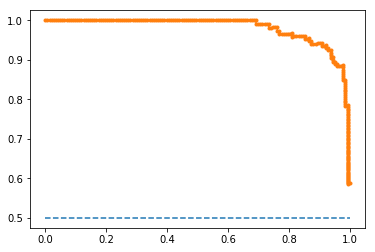

In [108]:
#We can also draw a diagram of a precision-recall curve
Prerec(X1_test,y1_test,logmodel1,predict1)

Precision, recall, and f1-score are used to understand how your data performs, especially on an imbalanced dataset. Our data is balanced, meaning the column to be classified has a 50/50 chance of being clicked on or not. 

*Precision* is the ratio of correctly predicted positive outcomes to all positively predicted outcomes - it essentially tells us "How many people actually clicked after being labeled they would?". 

*Recall* is the ratio of how many correctly predicted positive outcomes to how many people survived in total (thus including rows that the model labeled that they wouldn't click on the ad even though they actually did) - this answers the question "Of those who clicked on the ad, how many did we predict to do so?" 

The *F1-score* is a weighted average of Precision and recall. It's harder to interpret, but allows us to combine precision and recall and understand what the overall performance is to be used in comparison with other models. 

Remember that a completely random model would get 0.5 (50/50 chance) for these metrics, and a perfect model would be 1.0

It's also important to note that the classification report and the precision-recall curve metrics are different, even though they measure the same thing, due to how they are measured. The classification report only uses a binary yes/no outcome to measure these metrics, whereas the precision-recall curve breaks each row into a probability of being yes, causing the differences. Both are important to understand because both give slightly different answers depending on the question you are asking.

With this said, Anything over 0.9 is very good! But we'll also want to see what else we can learn about our model

AUC: 0.981


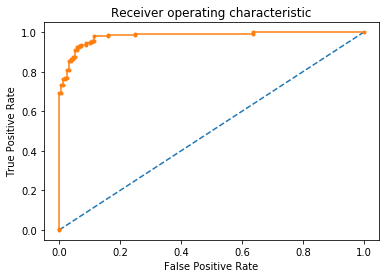

In [109]:
ROCAUC(X1_test,y1_test,logmodel1)

This is the ROC curve. The better then model, the larger the Area Under the Curve (AUC) and the farther away to the top left the model will be compared to the dotted line (a completely random model). Ours with an AUC of 0.98 is very good!

As we've observed so far, our model seems to be really good. But how can we apply this? 

Well, for starters, we can look at the Cumulative Accuracy Profile (CAP) Curve to help us understand how well, if we predicted a dataset, we could determine if they would click on an ad or not. Another way of thinking about this is that, by drawing a CAP curve, we can begin to isolate the customers that we are most confident in predicting for and understand what share of the overall population that we could do that for. 

In [110]:
#CAP curve
def CAP(xtest, ytest, modelname):
    """ Calculates the Cumulitive Accuracy Profile (CAP) curve"""
    from sklearn.metrics import auc
    
    total = len(ytest)
    class_1_count = np.sum(ytest)
    class_0_count = total - class_1_count
    plt.figure(figsize = (10,5))
    
    #First plot a random model
    _ = plt.plot([0,total],[0,class_1_count],c='r',linestyle='--',label='Random Model')
    #Plot Perfect model
    _ = plt.plot([0,class_1_count,total],[0,class_1_count,class_1_count],c='grey',linewidth=2,label='Perfect Model')
    #Now to add our model
    probs = modelname.predict_proba(xtest)
    #want only the probabilities for the positive outcome only
    probs=probs[:,1] 
    model_y = [y for _, y in sorted(zip(probs, ytest), reverse = True)]
    y_values = np.append([0], np.cumsum(model_y))
    x_values = np.arange(0, total + 1)
    _ = plt.plot(x_values,y_values,c='b',label='Predictive Model',linewidth=4)
    
    #50% mark line 
    index = int((50*total / 100))
    ## 50% Vertical line from x-axis
    plt.plot([index, index], [0, y_values[index]], c ='g', linestyle = '--')
    
    ## Horizontal line to y-axis from prediction model
    plt.plot([0, index], [y_values[index], y_values[index]], c = 'g', linestyle = '--')
    
    class_1_observed = y_values[index] * 100 / max(y_values)
    print("Percentage of Total Positive Outcomes at 50%: {}%".format(class_1_observed))
    
    #auc
    # Area under Random Model
    a = auc([0, total], [0, class_1_count])
    
    # Area between Perfect and Random Model
    aP = auc([0, class_1_count, total], [0, class_1_count, class_1_count]) - a
    
    # Area between Trained and Random Model
    aR = auc(x_values, y_values) - a

    print("Accuracy Ratio: {}".format(aR / aP*100))
    
    _ = plt.xlabel('Users Tested')
    _ = plt.ylabel('Clicked on Ad')
    _ = plt.title('Cumulative Accuracy Profile')   
    _ = plt.legend()
    
    plt.show()

Percentage of Total Positive Outcomes at 50%: 94.4055944055944%
Accuracy Ratio: 96.13380250322926


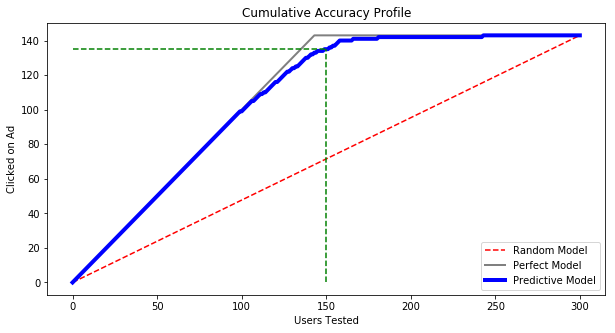

In [111]:
CAP(X1_test,y1_test,logmodel1)

We see that our percentage of total positive outcomes at 50% is 94%, which means that we can identify 94% of the people who will click on our ad by just applying our model to the top 50% of the users in our test data. Typically, anything above 90% is an exceptional model, meaning this model is very good. This is valuable information for budgeting for a given user set. To apply this concept, you could apply this model directly to each user coming in and only show the ad to users with a high probability rating or you could apply the model to a new data set of users and you could order the data by probability that they'll click the ad and then use this information to choose which users you want to contact out of the list.

But what we're primarily interested in is what variables/attributes of users are important for them to click on the ad according to our model. For that we'll create a coefficients report.

In [112]:
#In order to create a report using python, there can only be up to 35 fields. 
#Our country field is the main culprit for causing this problem. #
#Before we can print the report, we'll reduce the variables through Recursive Feature Elimination (RFE)
from sklearn.feature_selection import RFE
logreg1=LogisticRegression(solver = 'lbfgs')
rfe = RFE(logreg1, 35)
rfe=rfe.fit(X1,y1)
print(rfe.support_)
print(rfe.ranking_)

C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
C:\Users\Brandon\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", 

[False False False False False False False False False False False False
 False False False False False False  True False False False  True False
 False False False False False False False False False False False  True
 False False False False False False False False  True  True  True False
 False False False False False False False False False  True False False
 False  True False False False False False False False False False False
 False False False  True False False False  True False False  True  True
  True False False False False False False  True False False False False
 False False False False False False False False False  True False False
 False False False False False  True False False False False False  True
 False False False  True False  True False False False False  True False
 False False False False False False False False False False False False
 False False False False False False False  True False False False  True
 False False False False False False False False Fa

We see a lot of errors that there was a failure to converge, meaning that our country variable is made up of a much larger amount of dummy variables than our interation limitation (the number of variables we want to end up with at the end of the RFE). As this is a great opportunity to learn the limitations of RFE, I will continue in this logic and see how it affects our model performance.

In [113]:
ycolumns = pd.DataFrame(rfe.support_,X1.columns)
ycolumns.head()

,0
Daily Time Spent on Site,False
Age,False
Area Income,False
Daily Internet Usage,False
Male,False


In [114]:
ycolumns[ycolumns[0]==True]

,0
Antigua and Barbuda,True
Australia,True
Bolivia,True
Burundi,True
Cambodia,True
Cameroon,True
Congo,True
Croatia,True
Ethiopia,True
Finland,True


We see a very interesting thing here with the Recursive Feature Elimination - it's showing that the country that the user is from is a better indicator than any of the other features we have. To compare this to what we got, we can run a logistic regression on it.

In [115]:
ycolumns[ycolumns[0]==True][0].index

Index(['Antigua and Barbuda', 'Australia', 'Bolivia', 'Burundi', 'Cambodia',
       'Cameroon', 'Congo', 'Croatia', 'Ethiopia', 'Finland',
       'French Polynesia', 'French Southern Territories', 'Gabon', 'Greenland',
       'Hungary', 'Italy', 'Kenya', 'Kyrgyz Republic', 'Latvia',
       'Liechtenstein', 'Montenegro', 'Myanmar', 'Niue', 'Panama',
       'Saudi Arabia', 'Singapore', 'Spain', 'Swaziland', 'Sweden', 'Turkey',
       'Uganda', 'Ukraine', 'Uruguay', 'Vanuatu', 'Wallis and Futuna'],
      dtype='object')

In [116]:
X2 = X1[['Antigua and Barbuda', 'Australia', 'Bolivia', 'Cameroon', 'Croatia',
       'Ethiopia', 'Finland', 'French Polynesia',
       'French Southern Territories', 'Gabon', 'Greenland', 'Hungary', 'India',
       'Italy', 'Kenya', 'Kyrgyz Republic', 'Latvia', 'Liechtenstein', 'Macao',
       'Malaysia', 'Mayotte', 'Myanmar', 'Nicaragua', 'Niue', 'Panama',
       'Singapore', 'South Africa', 'Spain', 'Sri Lanka', 'Swaziland',
       'Turkey', 'Uganda', 'Ukraine', 'Uruguay', 'Vanuatu']]

In [117]:
X2.head()

,Antigua and Barbuda,Australia,Bolivia,Cameroon,Croatia,Ethiopia,Finland,French Polynesia,French Southern Territories,Gabon,...,Singapore,South Africa,Spain,Sri Lanka,Swaziland,Turkey,Uganda,Ukraine,Uruguay,Vanuatu
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [118]:
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y1, test_size=0.30, random_state=101)
logmodel2 = LogisticRegression(solver = 'lbfgs')
logmodel2.fit(X2_train,y2_train)
predict2 = logmodel2.predict(X2_test)
print(classification_report(y2_test,predict2))

              precision    recall  f1-score   support

           0       0.93      0.16      0.27       157
           1       0.52      0.99      0.68       143

   micro avg       0.55      0.55      0.55       300
   macro avg       0.72      0.57      0.47       300
weighted avg       0.73      0.55      0.47       300



As we can see, this second model had a really high precision for the negative outcome and a really high recall for the positive outcome, but we see that, as a model, it does not hold well. 

The RFE package is trying to find the best variables in a given limited number that you want (in this case we said the limit of our coefficient report package, which is 35) given ALL of the data. Because we ended up with only a fraction of all of the countries, we could really only reliably test for those data points when new data came, which is why the model went so poorly when we trained it and tested it on different datasets. 

What we can understand from this is that, because RFE only chose countries, that tells us that country must be a strong connection to whether a person will click on an ad or not. To test this theory, I'll run a logist regression model without using countries - if our model accuracy is reduced, then we know that country is important in whether someone will click on an ad or not.

In [119]:
X1.columns[:11]

Index(['Daily Time Spent on Site',                      'Age',
                    'Area Income',     'Daily Internet Usage',
                           'Male',                          2,
                                3,                          4,
                                5,                          6,
                                7],
      dtype='object')

In [120]:
X3 = X1[['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage','Male',2,3,4,5,6,7]]

In [121]:
X3.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,2,3,4,5,6,7
0,68.95,35,61833.90,256.09,0,0,1,0,0,0,0
1,80.23,31,68441.85,193.77,1,0,0,1,0,0,0
2,69.47,26,59785.94,236.50,0,0,1,0,0,0,0
3,74.15,29,54806.18,245.89,1,0,0,0,0,0,0
4,68.37,35,73889.99,225.58,0,0,0,0,0,1,0


In [122]:
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y1, test_size=0.30, random_state=101)
logmodel3 = LogisticRegression(solver = 'lbfgs')
logmodel3.fit(X3_train,y3_train)
predict3 = logmodel3.predict(X3_test)
print(classification_report(y3_test,predict3))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       157
           1       0.94      0.90      0.92       143

   micro avg       0.93      0.93      0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



In [123]:
print(classification_report(y1_test,predict1))

              precision    recall  f1-score   support

           0       0.91      0.95      0.93       157
           1       0.94      0.90      0.92       143

   micro avg       0.93      0.93      0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300



While the RFE identified the countries as having the most impact in predicting the target attribute, it's clear that including country had little to no effect on the performance of our model. This seems to be one of the limitations with RFE - if one variable is created into many dummy variable equivalents, it becomes difficult to use RFE if the dummy variable equivalents for one variable are far greater than the number of variables you are reducing to through RFE. 

While including the country in the analysis isn't a bad idea, as we've seen, it becomes harder to interpret due to limitations in using python packages. A better approach (for interpretabilty's sake) to get similar information would be to bin the countries into region, thereby reducing the number of dummy variables created when performing a logistic regression. As it is, if you are only after a model to predict, this method is fine when you are only interested in a better model. 

Now that we have reduced our number of variables down below the threshold, we can now use the stats package to create a coefficients report

In [124]:
Coefsum(X3,y1)

Optimization terminated successfully.
         Current function value: 0.236175
         Iterations 8
                             Results: Logit
Model:                Logit              Pseudo R-squared:   0.659      
Dependent Variable:   Clicked on Ad      AIC:                494.3503   
Date:                 2019-04-28 13:33   BIC:                548.3356   
No. Observations:     1000               Log-Likelihood:     -236.18    
Df Model:             10                 LL-Null:            -693.15    
Df Residuals:         989                LLR p-value:        6.3494e-190
Converged:            1.0000             Scale:              1.0000     
No. Iterations:       8.0000                                            
------------------------------------------------------------------------
                          Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
------------------------------------------------------------------------
Daily Time Spent on Site -0.0731   0.0090 -8.1185 0

From the coefficients report, we can compare the binary variables (everything but the months) through the sign it has in front of the coefficient. A negative coefficient says an increase in one unit will decrease the likelihood that someone will click on the ad, and the opposite would be true for a positive coefficient. For example, we see that an increase in age will increase the likelihood that a user will click on an ad. You could say the same for gender, but we see that the pvalue for Male is very large, meaning that gender most likely doesn't effect the likelihood as much (you could then take gender out of the model to make your model leaner and more apt to handle new data). On the other side, we see an increase in daily time spent on site and daily internet usage actually decreases their likelihood of clicking an ad, potentially due to being exhausted by too many ads the longer they are online. 

It should be noted that, while we can see if it increases or decreases, we can't interpret how much, by magnitude, it will increase of decrease. To be able to compare these variables and their effects a little more, we can calculate the odds ratios for each, which is a metric related to probability (often used by horse racing).

In [125]:
Oddsratio = pd.DataFrame(np.exp(logmodel3.coef_),columns=['Daily Time Spent on Site','Age','Area Income','Daily Internet Usage','Male',2,3,4,5,6, 7])

In [126]:
Oddsratio

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,2,3,4,5,6,7
0,0.950026,1.266383,0.99999,0.975622,1.001079,1.000575,1.000166,1.001145,1.001378,1.000695,1.000883


From this we can compare the variables a little better. Having an odds ratio between 0.8 and 1.2 isn't typically noteworthy, just that these variables do affect the odds of someone clicking on an ad. However, with Age being above 1.2, we could interpret this as being the biggest indicator of whether someone will click on an ad or not. Therefore, we could take this information and use it by focusing on targeting the older users, whether that means putting our ads on sites with a higher average age (within our age range for this data) or by targeting older users through our website or through a popular ad site like google or Facebook.

I also want to note that, because all of the month columns are roughly the same, it looks like the month doesn't effect the odds of someone clicking an ad as much. If you were hoping to mobilize a prediction algorithm, you would want to remove month as a predictor because there isn't information for all 12 months. 

# Conclusion
In this analysis, we made a model using logistic regression to help us try to predict whether or not users will click on our ads. We made an excellent model (at least partly attributed to having a fictional dataset). We also saw that, by splitting country into a dummy variable, we were unable to use Recursive Feature Elimination and we saw the effects of that on our model. We were able to interpret our model to help us understand what variables affect whether someone will click on an ad; namely, we found that an increase in Age had the largest impact on the odds of someone clicking our Ad. Finally, we noted along the way that our model could be used not only in predicting whether a future user will click on an ad or not, but also in other applications, from budgeting how much we should spend on advertising to identifying what kind of users we should target with our ad.